In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import nltk
from sklearn.cluster import DBSCAN
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import scipy.spatial.distance
from scipy.special import softmax
from scipy.spatial.distance import cdist
from sklearn import metrics
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return None
setup_mpl()

In [3]:
def plus_plus(X, k, random_state=42):
    '''
    ##########################
    #k-means++ initialization#
    ##########################
    
    The approach:
         * 1st centroid is chosen uniformly at random from the observations.
         * Subsequently, the remaining centroids are chosen from the remaining observation with probability
           proportionally with the squared distance to the closest existing centroid
    
    Parameters:
        * X : Observations, X \in R^{observations x features}
        * k : Number of centroids
    
    by Christian Djurhuus
    '''
    np.random.seed(random_state)
    
    # Allocating memory
    centroids = np.zeros((k, X.shape[1]))
    
    # Sampling first centroid uniformly at random from observations
    indicies = [i for i in range(X.shape[0])]
    first_idx = np.random.choice(indicies, size=1)
    indicies.remove(first_idx)
    centroids[0,:] = X[first_idx, :]

    # Determining remaining number of centroids:
    for i in range(1,k):
        print(f'Number of centroids defined: {i+1}')
        # Compute distance between all observations and existing centroids
        pair_dist = (((np.expand_dims(X[indicies,:], 1)-centroids[:i,:]+1e-06)**2).sum(-1))
        #pair_dist = cdist(X[indicies,:], centroids[:i,:], metric='euclidean')

        # Probabilities:
        if pair_dist.ndim==1:
            #only one centroid available. Hence, dist to nearest centroid is just pair dist
            dist = pair_dist
            #probs = (np.exp(dist) / np.sum(np.exp(dist), axis=0))
            probs = dist/dist.sum()
        else:
            dist = pair_dist.min(axis=1)
            #probs = (np.exp(dist) / np.sum(np.exp(dist), axis=0))
            probs = dist/dist.sum()


        #Selecting one of the remaining observations
        selected_idx = np.random.choice(indicies,size=1, p=probs)
        indicies.remove(selected_idx)
        centroids[i, :] = X[selected_idx, :]
    
    return centroids

In [4]:
def kmeans(X, k, random_state=42, tot=1e-4, n_init=10):
    #Substracting mean of data
    X -= X.mean(axis=0)

    best_inertia = 1e6

    #run n_init number of the kmeans algorithm and return clusters with minimum inertia
    for i in range(1, n_init+1):
        print(f'Kmeans run no. {i}')
        
        #Determining centroids using kmeans++
        centroids = plus_plus(X=X, k=k, random_state=i*random_state)

        #initial placeholder
        prev_centroids = np.zeros(centroids.shape)
        assignments = np.zeros(X.shape[0])

        #Run until convergence
        itr = 1
        diff = 1e5
        while not np.allclose(prev_centroids, centroids):
            print(f'Iteration number: {itr} - diff {diff}')
            prev_diff = diff
            prev_assignments = assignments

            #Using broadcasting to compute pairwise distances between observations and centroids
            dists=((np.expand_dims(X, 1)-centroids+1e-06)**2).sum(-1)**0.5
            assignments = dists.argmin(axis=1)
            prev_centroids = centroids.copy()

            #Update centroid position
            for idx in range(k):
                centroids[idx, :] = X[np.where(assignments==idx)].mean(axis=0)

            itr += 1


            #Distance between previous centroids and current
            diff = ((((prev_centroids - centroids + 1e-6)**2).sum(-1))**0.5).sum()

            #Early stopping when converged
            if np.array_equal(prev_assignments, assignments): #Check for strict convergence
                break

            if diff < tot: #Check for loose convergence
                break

        #Computing inertia
        #Sum of squared distance between each sample and its assigned center.
        #TODO: use broadcasting instead of for loop
        inertia = 0
        for idx in range(k):
            #inertia_dist = X[np.where(assignments==idx)] - centroids[idx, :]
            #inertia += (inertia_dist.T@inertia_dist).sum()
            inertia += np.sum((np.expand_dims(X[np.where(assignments==idx)],1) - centroids[idx, :]) ** 2, axis=0).sum() #squared dist
            #inertia += np.linalg.norm(X[np.where(assignments==idx)] - centroids[idx, :])**2

        if inertia < best_inertia:
            best_inertia = inertia
            print(f'Current best inertia: {best_inertia}')
            best_assignments = assignments
            best_centroids = centroids

    return best_assignments, best_centroids, best_inertia

In [5]:
def performance_metrics(X, assign, labels):
    ARI = metrics.adjusted_rand_score(labels, assign)
    NMI = metrics.adjusted_mutual_info_score(labels, assign)
    DBI = metrics.davies_bouldin_score(X, assign)
    
    print(f'ARI: {ARI:.3f}')
    print(f'NMI: {NMI:.3f}')
    print(f'DBI: {DBI:.3f}')
    print('\n')
    return ARI, NMI, DBI

In [6]:
df = pd.read_csv('CleanData/clean_spam.csv')
df['tokens'] = df['tokens'].apply(literal_eval)
df.head()

,label,text,tokens,str_tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, avail, bugi, n, great, wor...",go jurong point avail bugi n great world la e ...
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]",ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, wkli, comp, win, fa, cup, final,...",free entri wkli comp win fa cup final tkt may ...
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goe, usf, live, around, though]",nah think goe usf live around though


In [7]:
#TDIDF
def identity_tokenizer(text):
    return text

#vectorizer = TfidfVectorizer(analyzer='word',
#    tokenizer=identity_tokenizer,
#    preprocessor=identity_tokenizer,
#    token_pattern=None)

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False
                            )

vecs = vectorizer.fit_transform(df['tokens'])
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
TDM = pd.DataFrame(lst1, columns=feature_names).dropna()
X = vecs

# Original Space

## Choosing suitable K

In [98]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(X, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.9535712371843759
Iteration number: 3 - diff 0.04372178335085863
Iteration number: 4 - diff 0.00945944030874744
Iteration number: 5 - diff 0.0026841957759638213
Current best inertia: 5477.451103919042
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.807722899012472
Iteration number: 3 - diff 0.06450836861381834
Iteration number: 4 - diff 0.06062258748440079
Iteration number: 5 - diff 0.06521371950505697
Iteration number: 6 - diff 0.08200620013302004
Iteration number: 7 - diff 0.06373981490392132
Iteration number: 8 - diff 0.03854832166581815
Iteration number: 9 - diff 0.03298495068085701
Iteration number: 10 - diff 0.031317206271359796
Iteration number: 11 - diff 0.017209098963100702
Iteration number: 12 - diff 0.010235306381368258
Iteration number: 13 - diff 0.010721362514936082
Iteration number: 14 - diff 0.013

Iteration number: 3 - diff 0.07924544854093822
Iteration number: 4 - diff 0.05164164229396946
Iteration number: 5 - diff 0.04621428336499181
Iteration number: 6 - diff 0.01285146393620041
Iteration number: 7 - diff 0.010474441053769701
Kmeans run no. 6
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.8543233645211847
Iteration number: 3 - diff 0.09850900350760344
Iteration number: 4 - diff 0.13516204346168345
Iteration number: 5 - diff 0.13284138889756136
Iteration number: 6 - diff 0.06685764209248016
Iteration number: 7 - diff 0.03749083921903974
Iteration number: 8 - diff 0.03202248514753892
Iteration number: 9 - diff 0.020434179020661275
Iteration number: 10 - diff 0.0049194688338647565
Iteration number: 11 - diff 0.00430798111331898
Iteration number: 12 - diff 0.0076072695412659755
Iteration number: 13 - diff 0.0018867645002227614
Kmeans run no. 7
Number of centroids defined: 2
Number of centroids defined

Iteration number: 22 - diff 0.004503061142991285
Iteration number: 23 - diff 0.004564972432262831
Iteration number: 24 - diff 0.004522736754578486
Kmeans run no. 7
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 3.670482100031799
Iteration number: 3 - diff 0.21783216432023925
Iteration number: 4 - diff 0.19939324563336194
Iteration number: 5 - diff 0.08938251253678792
Iteration number: 6 - diff 0.12557167147277698
Iteration number: 7 - diff 0.15154577294795968
Iteration number: 8 - diff 0.08334902614299657
Iteration number: 9 - diff 0.020702636913436826
Iteration number: 10 - diff 0.012941644694550553
Iteration number: 11 - diff 0.010247891652953589
Iteration number: 12 - diff 0.0061957118946386345
Iteration number: 13 - diff 0.006211190846698873
Current best inertia: 5409.546998265049
Kmeans run no. 8
Number of centroids defined: 2
Number of centroids defined: 3
Number of centro

Number of centroids defined: 5
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 4.657472781364725
Iteration number: 3 - diff 0.21686753999905564
Iteration number: 4 - diff 0.17986226601880986
Iteration number: 5 - diff 0.18356006662658064
Iteration number: 6 - diff 0.16857472935586795
Iteration number: 7 - diff 0.1364113580510578
Iteration number: 8 - diff 0.13322116050962685
Iteration number: 9 - diff 0.11530449172061377
Iteration number: 10 - diff 0.07230377491409679
Iteration number: 11 - diff 0.04356681610517805
Iteration number: 12 - diff 0.031632626877647514
Iteration number: 13 - diff 0.008780354243339738
Iteration number: 14 - diff 0.006618892102932469
Iteration number: 15 - diff 0.004638077443930586
Iteration number: 16 - diff 0.003339523248261283
Iteration number: 17 - diff 0.004641600594396792
Kmeans run no. 7
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Iteration number: 1 - diff 10

Iteration number: 11 - diff 0.0237132093767683
Iteration number: 12 - diff 0.02275663787349619
Iteration number: 13 - diff 0.03237022200859747
Iteration number: 14 - diff 0.059054151465762456
Iteration number: 15 - diff 0.0221764157722375
Iteration number: 16 - diff 0.014967160331785401
Iteration number: 17 - diff 0.003815462788999929
Kmeans run no. 6
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.602431132491676
Iteration number: 3 - diff 0.32194686212748486
Iteration number: 4 - diff 0.2025923079119323
Iteration number: 5 - diff 0.14490359718435375
Iteration number: 6 - diff 0.11725035249494167
Iteration number: 7 - diff 0.08605305035735476
Iteration number: 8 - diff 0.09548625476056227
Iteration number: 9 - diff 0.09027784206275821
Iteration number: 10 - diff 0.07659860167992391
Iteration number: 11 - diff 0.0565

Kmeans run no. 4
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 6.335687902940919
Iteration number: 3 - diff 0.3346345339896287
Iteration number: 4 - diff 0.15576780741331403
Iteration number: 5 - diff 0.1278238589210072
Iteration number: 6 - diff 0.14287259363782878
Iteration number: 7 - diff 0.12401793728758868
Iteration number: 8 - diff 0.15743287103283563
Iteration number: 9 - diff 0.1921355166697688
Iteration number: 10 - diff 0.13126941240184636
Iteration number: 11 - diff 0.04219143116326705
Iteration number: 12 - diff 0.05653479496365999
Iteration number: 13 - diff 0.05880736582595072
Iteration number: 14 - diff 0.05468943840546986
Iteration number: 15 - diff 0.05282088833882554
Iteration number: 16 - diff 0.024040678024051017
Kmeans run no. 5
Number of centroids defined: 2
Numbe

Iteration number: 6 - diff 0.1688629783982335
Iteration number: 7 - diff 0.1757292227909924
Iteration number: 8 - diff 0.17493827156090536
Iteration number: 9 - diff 0.17460428176210727
Iteration number: 10 - diff 0.1819839192921921
Iteration number: 11 - diff 0.13992924944068624
Iteration number: 12 - diff 0.11135846974512038
Iteration number: 13 - diff 0.0727047138623757
Iteration number: 14 - diff 0.0670180679647726
Iteration number: 15 - diff 0.04217879120018543
Iteration number: 16 - diff 0.01842162649213944
Iteration number: 17 - diff 0.02502911457270171
Iteration number: 18 - diff 0.024244696048744654
Iteration number: 19 - diff 0.020482409586611478
Iteration number: 20 - diff 0.050848526710656955
Iteration number: 21 - diff 0.04429192289099321
Iteration number: 22 - diff 0.06747128421780643
Iteration number: 23 - diff 0.06566914696259323
Iteration number: 24 - diff 0.07560456788928314
Iteration number: 25 - diff 0.04391984409079494
Iteration number: 26 - diff 0.0453079321800206

Iteration number: 14 - diff 0.02474405382345985
Iteration number: 15 - diff 0.010064712367697307
Iteration number: 16 - diff 0.017137242350189996
Iteration number: 17 - diff 0.014936606944013857
Iteration number: 18 - diff 0.01694919079183023
Iteration number: 19 - diff 0.02108269620974761
Iteration number: 20 - diff 0.007969100482315299
Kmeans run no. 9
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 7.094754862779442
Iteration number: 3 - diff 0.40378226066553946
Iteration number: 4 - diff 0.4087265700652648
Iteration number: 5 - diff 0.2856608482696521
Iteration number: 6 - diff 0.15974344756682762
Iteration number: 7 - diff 0.0900979989398342
Iteration number: 8 - diff 0.09249109812546336
Iteration number: 9 - diff 0.03382745464857784
Iteration number: 1

Iteration number: 17 - diff 0.030541774084159874
Iteration number: 18 - diff 0.021072372747589215
Iteration number: 19 - diff 0.02776068075353504
Iteration number: 20 - diff 0.025398289894505762
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Number of centroids defined: 9
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 8.263342558878351
Iteration number: 3 - diff 0.5575194764321485
Iteration number: 4 - diff 0.3446718539636051
Iteration number: 5 - diff 0.19161111012597848
Iteration number: 6 - diff 0.13656223395680525
Iteration number: 7 - diff 0.10567616763230693
Iteration number: 8 - diff 0.08774196623890944
Iteration number: 9 - diff 0.13393723870158766
Iteration number: 10 - diff 0.041962711602211746
Iteration number: 11 - diff 0.026875649277747517
Iteration number: 12 - diff 0.0410

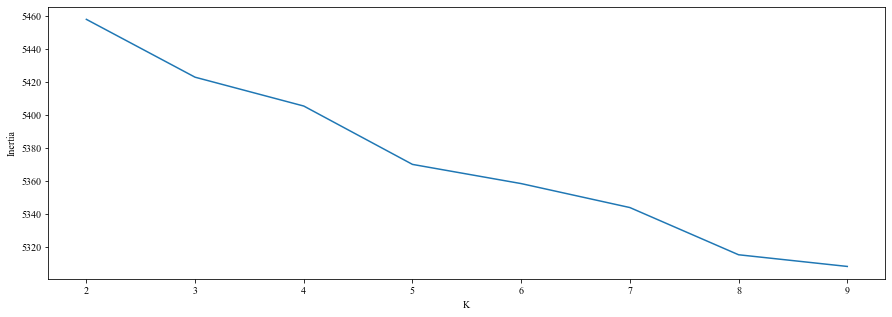

In [99]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

## Choosing suitable eps

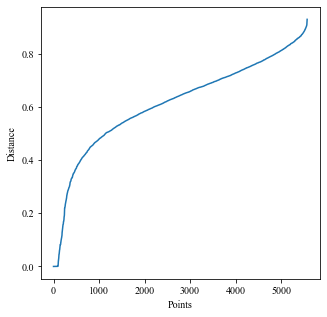

In [100]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 10
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors = nearest_neighbors.fit(X_svd)
distances, indices = neighbors.kneighbors(X_svd)
distances = np.sort(distances[:,n_neighbors-1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
#plt.xlim([0, 500])
plt.savefig("Distance_curve.png", dpi=300)

## Fitting models

In [101]:
from sklearn.cluster import DBSCAN
kmeans_assign, centroids, _ = kmeans(X, k=2, random_state=2, tot=1e-4)
clustering_db = DBSCAN(eps=0.1, min_samples=2).fit(X)
dbscan_assign = clustering_db.labels_

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.9535712371843759
Iteration number: 3 - diff 0.04372178335085863
Iteration number: 4 - diff 0.00945944030874744
Iteration number: 5 - diff 0.0026841957759638213
Current best inertia: 5477.451103919042
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.807722899012472
Iteration number: 3 - diff 0.06450836861381834
Iteration number: 4 - diff 0.06062258748440079
Iteration number: 5 - diff 0.06521371950505697
Iteration number: 6 - diff 0.08200620013302004
Iteration number: 7 - diff 0.06373981490392132
Iteration number: 8 - diff 0.03854832166581815
Iteration number: 9 - diff 0.03298495068085701
Iteration number: 10 - diff 0.031317206271359796
Iteration number: 11 - diff 0.017209098963100702
Iteration number: 12 - diff 0.010235306381368258
Iteration number: 13 - diff 0.010721362514936082
Iteration number: 14 - diff 0.013

In [104]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(X.toarray(), kmeans_assign, labels)
performance_metrics(X.toarray(), dbscan_assign, labels)

ARI: 0.352
NMI: 0.177
DBI: 6.265


ARI: 0.235
NMI: 0.125
DBI: 1.054




(0.23485910991012357, 0.12471939827184869, 1.0543316876657056)

# Dimensionality Reduction

#### TEMP
https://stats.stackexchange.com/questions/24493/how-to-reduce-dimension-for-text-document-dataset

In [62]:
from scipy.sparse.linalg import svds

In [63]:
num_components = 3
u, s, v = svds(X.toarray(), k=num_components)

In [64]:
A = u@(np.diag(s))

<IPython.core.display.Javascript object>


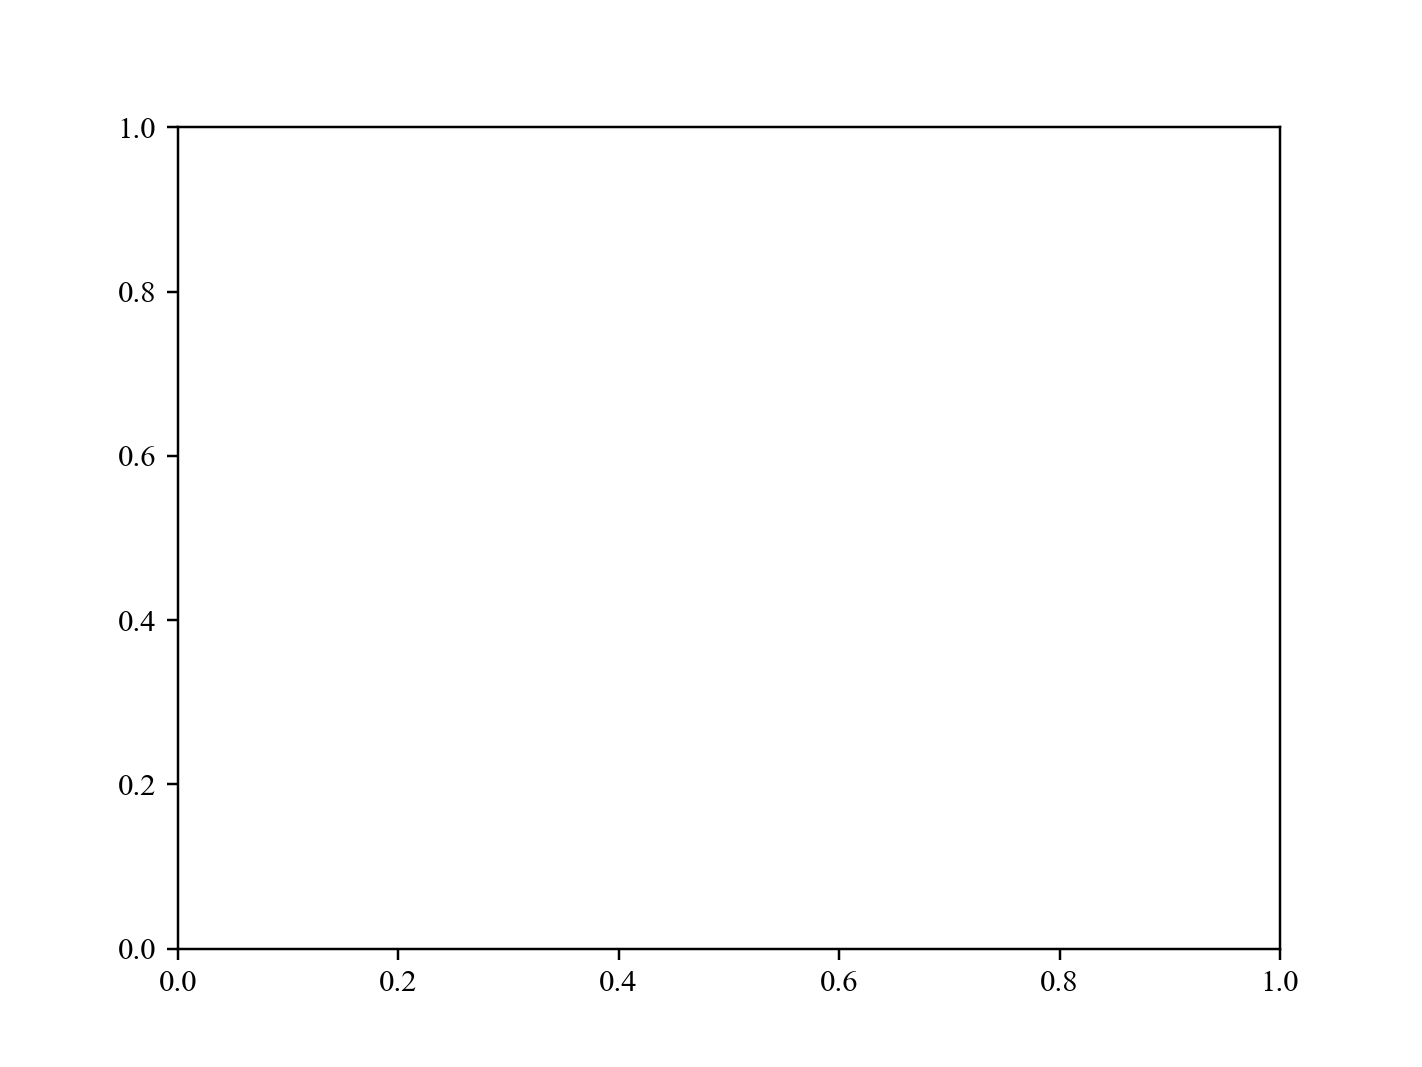

In [67]:
fig, ax = plt.subplots()
ax.scatter(A[:,1], A[:,2], c=labels)
plt.show()

In [59]:
from sklearn import decomposition
plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(X.toarray())
A = pca.transform(X.toarray())


In [45]:
%matplotlib notebook

<IPython.core.display.Javascript object>


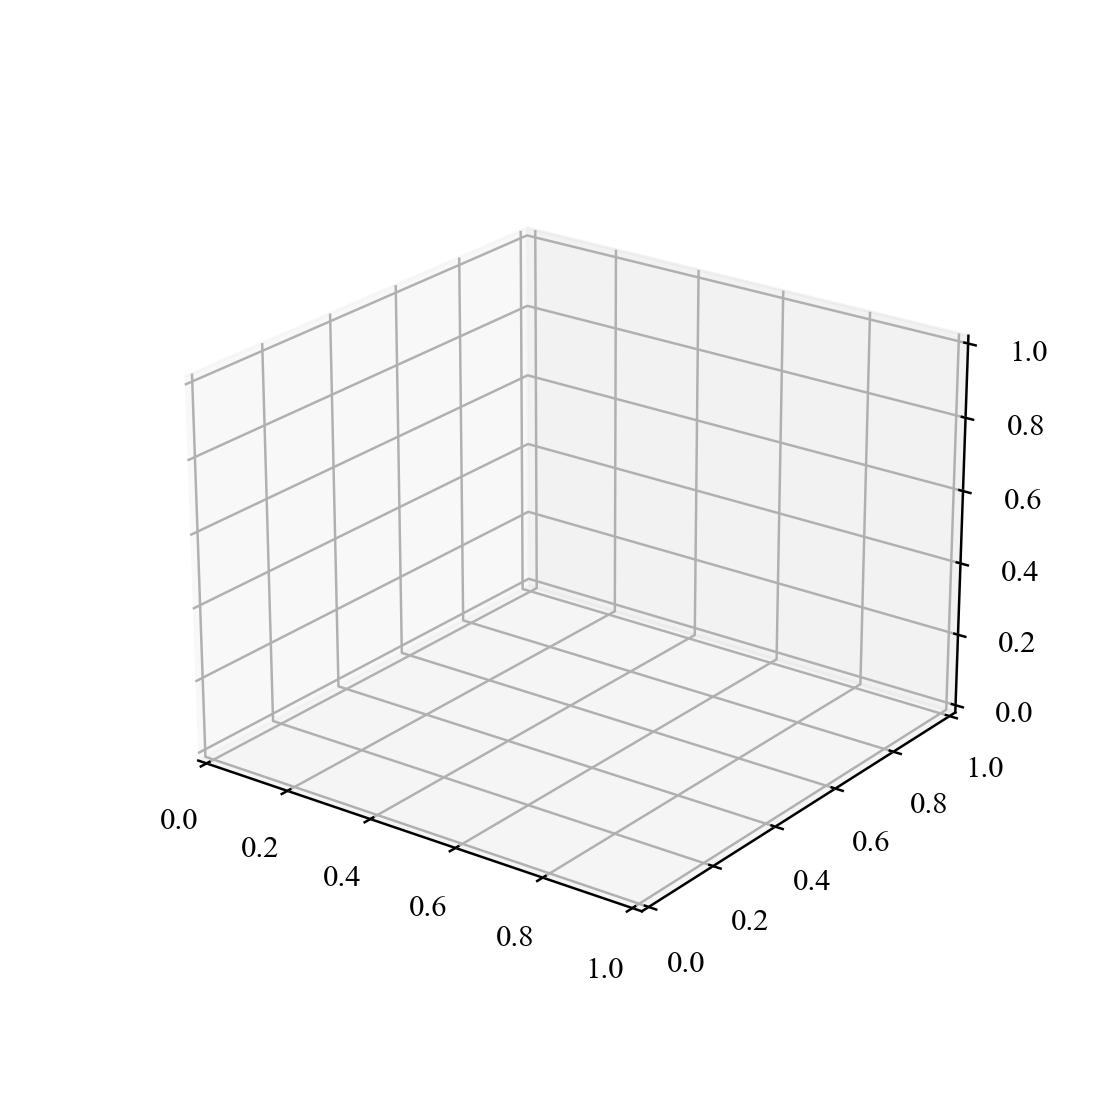

In [54]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(A[:,2], A[:,3], A[:,4], c=labels)
plt.show()


In [35]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=100, random_state=2)

svd_model.fit(X.toarray())

len(svd_model.components_)

2

In [36]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
u
 
call
 
later
 
ok
 
sorri
 
go
 
get
 
Topic 1: 
call
 
later
 
sorri
 
pleas
 
free
 
meet
 
prize
 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [60]:
assign, centroids, inertia = kmeans(A, k=2, random_state=2, tot=1e-4)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.15889143489300217
Iteration number: 3 - diff 0.04529550031312959
Iteration number: 4 - diff 0.043429898910533365
Iteration number: 5 - diff 0.018641868270732265
Iteration number: 6 - diff 0.010931780563543773
Iteration number: 7 - diff 0.01043585741506522
Iteration number: 8 - diff 0.022494548200144824
Iteration number: 9 - diff 0.009115300188466147
Iteration number: 10 - diff 0.012358236546928365
Iteration number: 11 - diff 0.005489832042338848
Current best inertia: 73.53327423751463
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.11245658362148203
Iteration number: 3 - diff 0.03166365022013687
Iteration number: 4 - diff 0.012510172494542234
Iteration number: 5 - diff 0.005455636890236551
Iteration number: 6 - diff 0.003028823119565419
Iteration number: 7 - diff 0.0018682043994270872
Iteration number: 8 - diff

In [61]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(A, assign, labels)

ARI: -0.053
NMI: 0.009
DBI: 0.696




(-0.052624643931381776, 0.008763783917506028, 0.6960129832146774)

#### End temp

SVD explaining 50 percent

In [8]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
X_svd = svd.fit_transform(X)
var_explained = svd.explained_variance_ratio_.sum()
print(var_explained)

0.5027743940846778


## Choosing most suitable K

In [41]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(X_svd, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.37158550294618
Iteration number: 3 - diff 0.0859862817074364
Iteration number: 4 - diff 0.04605707748212657
Iteration number: 5 - diff 0.02864667343645462
Iteration number: 6 - diff 0.04913372179286801
Iteration number: 7 - diff 0.04158163906669877
Iteration number: 8 - diff 0.016441895887499596
Iteration number: 9 - diff 0.029682273430212697
Current best inertia: 4415.057794238325
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.265030524846054
Iteration number: 3 - diff 0.16699832829814748
Iteration number: 4 - diff 0.15040209721082667
Iteration number: 5 - diff 0.059680135083580506
Iteration number: 6 - diff 0.04470873888816847
Iteration number: 7 - diff 0.05566644852203306
Iteration number: 8 - diff 0.0744206615249544
Iteration number: 9 - diff 0.07957434393883905
Iteration number: 10 - diff 0.05976517040874

Iteration number: 2 - diff 2.429652372118892
Iteration number: 3 - diff 0.19674720202661103
Iteration number: 4 - diff 0.1215089213532088
Iteration number: 5 - diff 0.057754636576093706
Iteration number: 6 - diff 0.028935351634105457
Iteration number: 7 - diff 0.03337132538411238
Iteration number: 8 - diff 0.013929870998567075
Iteration number: 9 - diff 0.0020615360757272054
Kmeans run no. 4
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.58669235091776
Iteration number: 3 - diff 0.13185549751043216
Iteration number: 4 - diff 0.05486133615563417
Iteration number: 5 - diff 0.04163609308118203
Iteration number: 6 - diff 0.055259153451723886
Iteration number: 7 - diff 0.060068861001446996
Iteration number: 8 - diff 0.05806039004997364
Iteration number: 9 - diff 0.047078790698035146
Iteration number: 10 - diff 0.0852566516612317
Iteration number: 11 - diff 0.06527432745967172
Iteration number: 12 - diff 0.021963

Iteration number: 17 - diff 0.0012948531070437078
Kmeans run no. 4
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 3.408039327137474
Iteration number: 3 - diff 0.3204648822126102
Iteration number: 4 - diff 0.15091827258655266
Iteration number: 5 - diff 0.09333715981713793
Iteration number: 6 - diff 0.06292229840446023
Iteration number: 7 - diff 0.049165339719874385
Iteration number: 8 - diff 0.04717040579774381
Iteration number: 9 - diff 0.011446636632706559
Iteration number: 10 - diff 0.004775425578646747
Iteration number: 11 - diff 0.007707491299599979
Iteration number: 12 - diff 0.009543884854203932
Current best inertia: 4333.952984142888
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.5478198304338355
Iteration number: 3 - diff 0.5847838522211266
Iter

Iteration number: 3 - diff 0.4036774324100155
Iteration number: 4 - diff 0.2022428378904733
Iteration number: 5 - diff 0.13020142819515895
Iteration number: 6 - diff 0.07861211157555127
Iteration number: 7 - diff 0.04337766629846734
Iteration number: 8 - diff 0.023524490563895026
Iteration number: 9 - diff 0.010745117838288855
Iteration number: 10 - diff 0.007818372942792907
Iteration number: 11 - diff 0.007635368445176807
Iteration number: 12 - diff 0.007286108240724367
Current best inertia: 4317.680573525818
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 3.1424918433656073
Iteration number: 3 - diff 0.624548656342928
Iteration number: 4 - diff 0.3778738373694334
Iteration number: 5 - diff 0.1910661823540893
Iteration number: 6 - diff 0.17182802790116708
Iteration number: 7 - diff 0.07495543899849746
Iteration number: 8 - diff 0.0

Iteration number: 17 - diff 0.04659351758731043
Iteration number: 18 - diff 0.020240577917870452
Iteration number: 19 - diff 0.010729842241126096
Iteration number: 20 - diff 0.011988802586364571
Iteration number: 21 - diff 0.015553932730661702
Iteration number: 22 - diff 0.028489358809016773
Iteration number: 23 - diff 0.039982730846462346
Current best inertia: 4303.761965900975
Kmeans run no. 4
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.054971738475298
Iteration number: 3 - diff 0.4835399786215769
Iteration number: 4 - diff 0.26061394637481505
Iteration number: 5 - diff 0.17129451896925454
Iteration number: 6 - diff 0.07871464695008126
Iteration number: 7 - diff 0.037061721434968546
Iteration number: 8 - diff 0.024283965350298867
Iteration number: 9 - diff 0.010965248072899796
Iteration number: 10 - diff 0.0090

Iteration number: 7 - diff 0.18520985864763298
Iteration number: 8 - diff 0.21756994392726514
Iteration number: 9 - diff 0.17378995005406303
Iteration number: 10 - diff 0.0853985083643407
Iteration number: 11 - diff 0.1464834242449409
Iteration number: 12 - diff 0.11746818260127515
Iteration number: 13 - diff 0.1436786552500971
Iteration number: 14 - diff 0.11217305306640285
Iteration number: 15 - diff 0.0704911483224016
Iteration number: 16 - diff 0.028289126082756466
Iteration number: 17 - diff 0.011393835664050849
Iteration number: 18 - diff 0.026139617364160057
Iteration number: 19 - diff 0.00885157013374521
Iteration number: 20 - diff 0.0074899990603149854
Iteration number: 21 - diff 0.00670265830881828
Iteration number: 22 - diff 0.002982132809452429
Iteration number: 23 - diff 0.004306976749195046
Iteration number: 24 - diff 0.0039165541320023535
Iteration number: 25 - diff 0.001909105648691533
Iteration number: 26 - diff 0.004048487557690755
Iteration number: 27 - diff 0.004671

Iteration number: 15 - diff 0.027312211829330413
Iteration number: 16 - diff 0.006473724571798888
Iteration number: 17 - diff 0.001704245764268582
Kmeans run no. 8
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.183162429406845
Iteration number: 3 - diff 0.908648576454419
Iteration number: 4 - diff 0.4400011331708151
Iteration number: 5 - diff 0.3108254012590264
Iteration number: 6 - diff 0.11192814145679023
Iteration number: 7 - diff 0.051211745112341556
Iteration number: 8 - diff 0.025738768107438588
Iteration number: 9 - diff 0.020735693753189843
Iteration number: 10 - diff 0.009632843595088507
Iteration number: 11 - diff 0.01306227224701883
Kmeans run no. 9
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Num

Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.293569965572548
Iteration number: 3 - diff 1.1789026280490762
Iteration number: 4 - diff 0.6843473904600705
Iteration number: 5 - diff 0.3938696119597198
Iteration number: 6 - diff 0.26392523274095625
Iteration number: 7 - diff 0.11314234784897474
Iteration number: 8 - diff 0.10448721655711879
Iteration number: 9 - diff 0.09077172594278127
Iteration number: 10 - diff 0.0027480153718119037
Kmeans run no. 6
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 6.136456160168967
Iteration number: 3 - diff 0.5959661514614689
Iteration number: 4 - diff 0.5205358589252377
Iteration nu

Number of centroids defined: 9
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.7200605182693804
Iteration number: 3 - diff 0.9915221200585456
Iteration number: 4 - diff 0.559305793616495
Iteration number: 5 - diff 0.2869405502944233
Iteration number: 6 - diff 0.15721648380124723
Iteration number: 7 - diff 0.09344248776465587
Iteration number: 8 - diff 0.08368922575066043
Iteration number: 9 - diff 0.0943097501963521
Iteration number: 10 - diff 0.12708630048700884
Iteration number: 11 - diff 0.09006286361950781
Iteration number: 12 - diff 0.13409248675657412
Iteration number: 13 - diff 0.2137170588773092
Iteration number: 14 - diff 0.09082129522016223
Iteration number: 15 - diff 0.05328793908548561
Iteration number: 16 - diff 0.028773199372362685
Iteration number: 17 - diff 0.04267374848349939
Iteration number: 18 - diff 0.03956444886398403
Iteration number: 19 - diff 0.02420679840716319
Iteration number: 20 - diff 0.03208191391105161
Iteration number: 21 - diff 0.03598

Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Number of centroids defined: 9
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 7.22408879467117
Iteration number: 3 - diff 0.7147078659965128
Iteration number: 4 - diff 0.5475934406007716
Iteration number: 5 - diff 0.4121724570734377
Iteration number: 6 - diff 0.22478246561702928
Iteration number: 7 - diff 0.2012043527191145
Iteration number: 8 - diff 0.17200410062119859
Iteration number: 9 - diff 0.15565995577274713
Iteration number: 10 - diff 0.11728732293641309
Iteration number: 11 - diff 0.12305712020050788
Iteration number: 12 - diff 0.23252300999915282
Iteration number: 13 - diff 0.1758777393383845
Iteration number: 14 - diff 0.14580794080334808
Iteration number: 15 - diff 0.07889490892050227
Iteration number: 16 - diff 0.05743098161952392
Iteration number: 17 - diff 0.02937680434113498
Iteration number: 18 - diff 0.017643420517640382
Iteratio

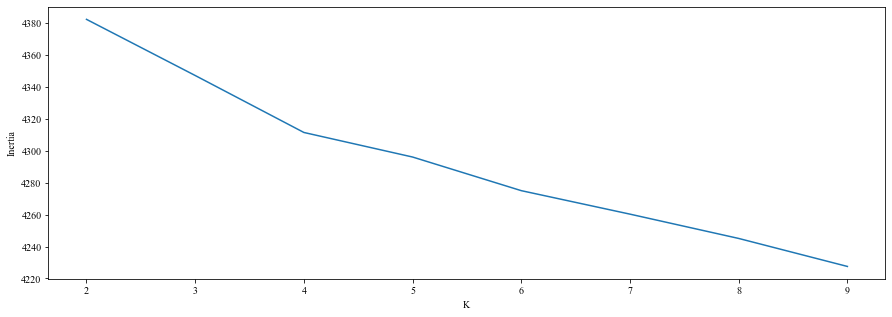

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

## Choosing most suitable eps

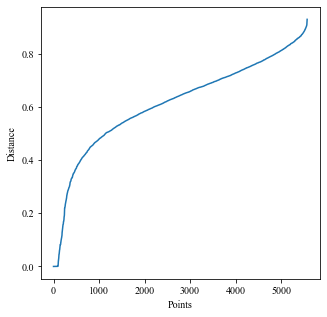

In [79]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 10
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors = nearest_neighbors.fit(X_svd)
distances, indices = neighbors.kneighbors(X_svd)
distances = np.sort(distances[:,n_neighbors-1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
#plt.xlim([0, 500])
plt.savefig("Distance_curve.png", dpi=300)

## Fitting optimal models

In [12]:
from sklearn.cluster import DBSCAN

In [13]:
clustering_db = DBSCAN(eps=0.1, min_samples=2).fit(X_svd)
dbscan_assign = clustering_db.labels_

In [14]:
kmeans_assign, centroids, _ = kmeans(X_svd, k=2, random_state=2, tot=1e-4, n_init=10)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.9296803437180579
Iteration number: 3 - diff 0.09435704111732324
Iteration number: 4 - diff 0.05724565286291704
Iteration number: 5 - diff 0.04411311754026707
Iteration number: 6 - diff 0.015977674251714917
Iteration number: 7 - diff 0.007298882217579771
Iteration number: 8 - diff 0.0038537015236703533
Iteration number: 9 - diff 0.002127497740662633
Iteration number: 10 - diff 0.0014890403748451296
Current best inertia: 2727.812691840436
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.494807708738465
Iteration number: 3 - diff 0.0817891016263654
Iteration number: 4 - diff 0.04910683507656775
Iteration number: 5 - diff 0.04230313777946362
Iteration number: 6 - diff 0.02667409810543979
Iteration number: 7 - diff 0.026759198129729534
Iteration number: 8 - diff 0.020245196878709168
Iteration number: 9 - diff 0.00703

In [15]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(X_svd, kmeans_assign, labels)
performance_metrics(X_svd, dbscan_assign, labels)

ARI: 0.358
NMI: 0.181
DBI: 4.684


ARI: 0.236
NMI: 0.130
DBI: 1.031




(0.2364707956144423, 0.13044013095907814, 1.03056461556023)

## Cosine Distance

In [42]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics.pairwise import cosine_similarity
dist = pairwise_distances(X, metric='cosine')
similarity = cosine_similarity(X)

## Choosing K (Standard K-means on dist)

In [106]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(dist, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.306247197225021
Iteration number: 3 - diff 0.14378243238283495
Current best inertia: 43062.82902512172
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.0079373557182905
Iteration number: 3 - diff 0.520361621090845
Iteration number: 4 - diff 0.8914635155507693
Iteration number: 5 - diff 0.9271371801931617
Iteration number: 6 - diff 0.20560032870759365
Iteration number: 7 - diff 0.09223767099552117
Iteration number: 8 - diff 0.058975712111477015
Iteration number: 9 - diff 0.08449319022849947
Iteration number: 10 - diff 0.11599782989232485
Iteration number: 11 - diff 0.1820479127697677
Iteration number: 12 - diff 0.3224048366697394
Iteration number: 13 - diff 0.21864626276166424
Iteration number: 14 - diff 0.05681088271389852
Iteration number: 15 - diff 0.03255179946756343
Iteration number: 16 - diff 0.016458007366

Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 6.78337155905896
Iteration number: 3 - diff 1.2677776928497857
Iteration number: 4 - diff 1.0934084747429584
Iteration number: 5 - diff 0.6326767214379904
Iteration number: 6 - diff 0.39218772214270353
Iteration number: 7 - diff 0.21217166824709363
Iteration number: 8 - diff 0.12208028849001826
Iteration number: 9 - diff 0.12887945328340417
Iteration number: 10 - diff 0.10263349191168544
Iteration number: 11 - diff 0.04745874773699135
Iteration number: 12 - diff 0.0494060522543814
Iteration number: 13 - diff 0.03406661526821066
Iteration number: 14 - diff 0.03802570281915206
Iteration number: 15 - diff 0.03174713966027214
Iteration number: 16 - diff 0.048139721078531844
Iteration number: 17 - diff 0.027187260667241635
Iteration number: 18 - diff 0.029199528375651786
Iteration number: 19 - diff 0.02389985954930221
Iteration number: 20 - diff 0.018242797912241735
Iteration number: 21 - diff 0.02

Iteration number: 4 - diff 1.0771870011195164
Iteration number: 5 - diff 0.43134926166049364
Iteration number: 6 - diff 0.26054761411423366
Iteration number: 7 - diff 0.28840443711948904
Iteration number: 8 - diff 0.22725458439190632
Iteration number: 9 - diff 0.164825645060479
Iteration number: 10 - diff 0.10626740074945731
Iteration number: 11 - diff 0.06354510430644066
Iteration number: 12 - diff 0.07123992817418617
Iteration number: 13 - diff 0.02437888482669662
Iteration number: 14 - diff 0.025231500495940935
Iteration number: 15 - diff 0.02099267245953492
Iteration number: 16 - diff 0.019331026387408877
Iteration number: 17 - diff 0.018922432767534792
Iteration number: 18 - diff 0.05265841348974338
Iteration number: 19 - diff 0.038062045499093505
Iteration number: 20 - diff 0.06075642724026844
Iteration number: 21 - diff 0.03585660013601537
Iteration number: 22 - diff 0.03448252608612252
Iteration number: 23 - diff 0.0421228777459425
Iteration number: 24 - diff 0.0445193765719533

Iteration number: 25 - diff 0.03573541552759448
Kmeans run no. 3
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 9.477379582114596
Iteration number: 3 - diff 1.6596278756522282
Iteration number: 4 - diff 1.3997585732205666
Iteration number: 5 - diff 1.0330403352245425
Iteration number: 6 - diff 1.4285637962205397
Iteration number: 7 - diff 1.4609392844320372
Iteration number: 8 - diff 0.658037685225677
Iteration number: 9 - diff 0.28104898642027604
Iteration number: 10 - diff 0.2895463634716691
Iteration number: 11 - diff 0.16056426673609794
Iteration number: 12 - diff 0.10252562579523739
Iteration number: 13 - diff 0.05801634796816952
Iteration number: 14 - diff 0.027576074365323187
Current best inertia: 38024.69074486526
Kmeans run no. 4
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroid

Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 12.563195887186623
Iteration number: 3 - diff 2.2564041074326915
Iteration number: 4 - diff 2.3553081759172194
Iteration number: 5 - diff 2.387454635500368
Iteration number: 6 - diff 1.2359765077738378
Iteration number: 7 - diff 0.6224051527768524
Iteration number: 8 - diff 0.5482744818482993
Iteration number: 9 - diff 0.6210286066457522
Iteration number: 10 - diff 0.4453614300455647
Iteration number: 11 - diff 0.6826572433473596
Iteration number: 12 - diff 0.7097770721429483
Iteration number: 13 - diff 0.8135237573335914
Iteration number: 14 - diff 0.9893465517323561
Iteration number: 15 - diff 0.49291662311419526
Iteration number: 16 - diff 0.2063627972384758
Iteration number: 17 - diff 0.13873570132056287
Iteration number: 18 - diff 0.11753968201777351
Iteration number: 19 - diff 0.07582802192021151

Number of centroids defined: 6
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 11.122628225935975
Iteration number: 3 - diff 2.957159800516792
Iteration number: 4 - diff 1.448340771345177
Iteration number: 5 - diff 1.1710441187145957
Iteration number: 6 - diff 1.0109694082635383
Iteration number: 7 - diff 0.6998587211964183
Iteration number: 8 - diff 0.6324789621047496
Iteration number: 9 - diff 0.3723070642004488
Iteration number: 10 - diff 0.30584224672200916
Iteration number: 11 - diff 0.25773792313385774
Iteration number: 12 - diff 0.17353200532360702
Iteration number: 13 - diff 0.32082748497709374
Iteration number: 14 - diff 0.43454947175166403
Iteration number: 15 - diff 0.06104499119807845
Iteration number: 16 - diff 0.03410403788208763
Iteration number: 17 - diff 0.010893712482829842
Iteration number: 18 - diff 0.009011818321886635
Iteration number: 19 - diff 0.004861856091093356
Kmeans run no. 9
Number of centroids defined: 2
Number of centroids defined: 3
Numbe

Iteration number: 6 - diff 1.0472964064916004
Iteration number: 7 - diff 1.3299493856140792
Iteration number: 8 - diff 1.1862613680859961
Iteration number: 9 - diff 1.689912506352864
Iteration number: 10 - diff 2.508253379274592
Iteration number: 11 - diff 1.1499712764326924
Iteration number: 12 - diff 0.41546455063041177
Iteration number: 13 - diff 0.1784114015978029
Iteration number: 14 - diff 0.2092592605799665
Iteration number: 15 - diff 0.1035103316822861
Iteration number: 16 - diff 0.0989465118274307
Iteration number: 17 - diff 0.01451450271683237
Iteration number: 18 - diff 0.004271063959292142
Current best inertia: 36194.29511066685
Kmeans run no. 4
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 14.655425716371136
Iteration number: 3 - diff 3.321373214448568
Iteration number: 4 -

Iteration number: 12 - diff 0.16743139639916815
Iteration number: 13 - diff 0.11464007059056366
Iteration number: 14 - diff 0.13259065417565927
Iteration number: 15 - diff 0.03860290611356848
Iteration number: 16 - diff 0.03671796055026276
Iteration number: 17 - diff 0.06638401687362214
Iteration number: 18 - diff 0.1342099721021525
Iteration number: 19 - diff 0.10164212654321125
Iteration number: 20 - diff 0.19481645319012497
Iteration number: 21 - diff 0.36899477567156375
Iteration number: 22 - diff 0.4095213924049452
Iteration number: 23 - diff 0.3785427947407233
Iteration number: 24 - diff 0.228259283720874
Iteration number: 25 - diff 0.12998071786166104
Iteration number: 26 - diff 0.1028748939567452
Iteration number: 27 - diff 0.08666965294492747
Iteration number: 28 - diff 0.10958932480530328
Iteration number: 29 - diff 0.08829885183553882
Iteration number: 30 - diff 0.04261754103116739
Iteration number: 31 - diff 0.058592244299607646
Iteration number: 32 - diff 0.073379435690816

Iteration number: 3 - diff 5.663357502053078
Iteration number: 4 - diff 2.974663984867539
Iteration number: 5 - diff 1.3034490200823738
Iteration number: 6 - diff 0.7937414415039771
Iteration number: 7 - diff 0.5630271637037902
Iteration number: 8 - diff 0.324698801844742
Iteration number: 9 - diff 0.1735548126965195
Iteration number: 10 - diff 0.09793612803044088
Iteration number: 11 - diff 0.06682720824219743
Iteration number: 12 - diff 0.04399656913039508
Kmeans run no. 6
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 16.71911163319782
Iteration number: 3 - diff 4.281280637030003
Iteration number: 4 - diff 2.5538836655725357
Iteration number: 5 - diff 2.408599756656891
Iteration number: 6 - diff 1.7117797056403976
Iteration number: 7 - diff 1.18441276166

Iteration number: 16 - diff 0.24135321063056112
Iteration number: 17 - diff 0.3617875430097719
Iteration number: 18 - diff 0.3567396909712995
Iteration number: 19 - diff 0.18087044791122614
Iteration number: 20 - diff 0.057098364363143014
Iteration number: 21 - diff 0.05504305253317543
Iteration number: 22 - diff 0.020345987421216325
Kmeans run no. 3
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Number of centroids defined: 9
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 15.633850483428137
Iteration number: 3 - diff 3.5478622690562394
Iteration number: 4 - diff 2.097188839247258
Iteration number: 5 - diff 1.3540215825946893
Iteration number: 6 - diff 0.9240263900835004
Iteration number: 7 - diff 1.0321792981982796
Iteration number: 8 - diff 0.6188095185876771
Iteration number: 9 - diff 0.5674792176767

Iteration number: 12 - diff 0.06291514095678359
Iteration number: 13 - diff 0.018973196016905995
Iteration number: 14 - diff 0.012599057016482467
Kmeans run no. 10
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Number of centroids defined: 9
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 18.285202381170105
Iteration number: 3 - diff 6.687099085519883
Iteration number: 4 - diff 4.55344727944472
Iteration number: 5 - diff 4.892239474526026
Iteration number: 6 - diff 2.129224760054792
Iteration number: 7 - diff 1.5077005672925912
Iteration number: 8 - diff 0.9517276740089008
Iteration number: 9 - diff 0.4603068551761337
Iteration number: 10 - diff 0.30314126054989743
Iteration number: 11 - diff 0.16185419530811013
Iteration number: 12 - diff 0.16176422297214738
Iteration number: 13 - diff 0.158748855934537

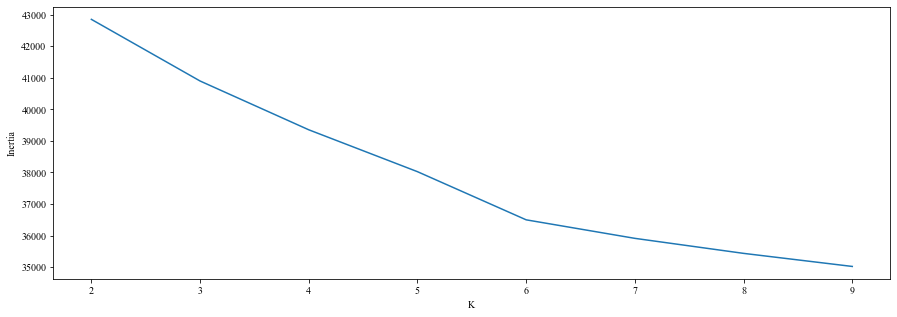

In [107]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

## Choosing eps (DBSCAN)

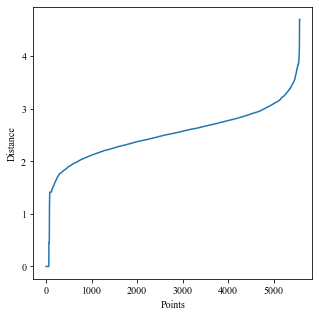

In [108]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=100)
neighbors = nearest_neighbors.fit(dist)
distances, indices = neighbors.kneighbors(dist)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
#plt.xlim([0, 500])
plt.savefig("Distance_curve.png", dpi=300)

# Spectral clustering
http://www.cis.hut.fi/Opinnot/T-61.6020/2008/spectral_kmeans.pdf

In [142]:
# Define affinity matrix
A = similarity
#Seems to be an issue with sklearns cosine similarity
#some diag elements equal zero, which it shouldn't
#The following fixes the issue
np.fill_diagonal(A, 0.0)
row_sum = A.sum(0)
removed_idx = np.where(A.sum(0)==0)[0]
A_reduced = A[row_sum != 0, :]
A_reduced = A_reduced[:, row_sum!=0]

assert np.where(A_reduced.sum(0)==0)[0].size == 0
assert np.where(A_reduced.sum(1)==0)[0].size == 0

# Define D as a diagonal matrix where element (i,i) corresponds to the sum of ith row in A
D = np.diag(A_reduced.sum(axis=0))
D_pow = np.diag(np.power(np.diagonal(D), -0.5))
# Define L=D^{-1/2}AD^{-1/2}
L = D_pow@A_reduced@D_pow

In [143]:
# Find the k largest eigenvectors of L
eigenvals, eigenvectors = np.linalg.eigh(L)

In [257]:
k = 10
k_largest = np.argpartition(eigenvals, -k)[-k:]

In [258]:
#Create matrix X_spec = [x1,...,xk]
X_spec = eigenvectors[:, k_largest]

In [259]:
# Define Y as X row normalized
Y = X_spec/np.linalg.norm(X_spec, axis=0)

In [260]:
row_sums = np.power(X_spec, 2).sum(axis=1)
#row_sums = X_spec.sum(axis=1)
Y = (X_spec / np.power(row_sums[:, np.newaxis], 0.5))
#Y = X_spec / row_sums[:, np.newaxis]
Y = np.nan_to_num(Y)

In [278]:
kmeans_spec_assign, centroids, _ = kmeans(Y, k=2, random_state=2, tot=1e-4)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.7868392292064342
Iteration number: 3 - diff 0.1804168790903128
Iteration number: 4 - diff 0.06230753325410987
Iteration number: 5 - diff 0.018998379907917785
Iteration number: 6 - diff 0.008747538142850972
Iteration number: 7 - diff 0.0017803248908155754
Current best inertia: 1202.8668709647936
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.31862210057336193
Iteration number: 3 - diff 0.04999446899172353
Iteration number: 4 - diff 0.007692391668446831
Iteration number: 5 - diff 0.005288433572482951
Iteration number: 6 - diff 0.0035609159918580475
Kmeans run no. 3
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.6830260734773519
Iteration number: 3 - diff 0.14344599851583004
Iteration number: 4 - diff 0.0728916366544949
Iteration number: 5 - diff 0.0506807684078138

In [291]:
labels = df.drop(removed_idx).label.replace({'ham':0, 'spam':1}).values
performance_metrics(Y, kmeans_spec_assign, labels)

ARI: 0.476
NMI: 0.317
DBI: 0.725




(0.47629594344261167, 0.3174677543841501, 0.7252779219911366)

## Fitting models

In [263]:
dist = pairwise_distances(X, metric='cosine')
kmeans_assign, centroids_kmeans, _ = kmeans(dist, k=2, random_state=2, tot=0.0001, n_init=10)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.306247197225021
Iteration number: 3 - diff 0.14378243238283495
Current best inertia: 43062.82902512172
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.0079373557182905
Iteration number: 3 - diff 0.520361621090845


KeyboardInterrupt: 

In [112]:
dist = pairwise_distances(X, metric='cosine')
clustering_db = DBSCAN(eps=0.1, min_samples=2, metric='precomputed').fit(dist)
dbscan_assign = clustering_db.labels_

In [113]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(dist, kmeans_assign, labels)
performance_metrics(dist, dbscan_assign, labels)

ARI: 0.339
NMI: 0.163
DBI: 2.618


ARI: 0.304
NMI: 0.153
DBI: 0.917




(0.30359508003019087, 0.15264210493506888, 0.916653192384555)

# Reducing sparsity by removal of features
https://stats.stackexchange.com/questions/230992/tfidf-for-feature-selection

In [100]:
def identity_tokenizer(text):
    return text

#vectorizer = TfidfVectorizer(analyzer='word',
#    tokenizer=identity_tokenizer,
#    preprocessor=identity_tokenizer,
#    token_pattern=None)

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False,
                            )

vecs = vectorizer.fit_transform(df['tokens'])
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
TDM = pd.DataFrame(lst1, columns=feature_names).dropna()
X = vecs

In [101]:
X.shape

(5572, 5756)

In [102]:
assign, centroids, inertia = kmeans(X, k=2, random_state=2, tot=1e-4)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.9535712371843759
Iteration number: 3 - diff 0.04372178335085863
Iteration number: 4 - diff 0.00945944030874744
Iteration number: 5 - diff 0.0026841957759638213
Current best inertia: 5477.451103919042
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.807722899012472
Iteration number: 3 - diff 0.06450836861381834
Iteration number: 4 - diff 0.06062258748440079
Iteration number: 5 - diff 0.06521371950505697
Iteration number: 6 - diff 0.08200620013302004
Iteration number: 7 - diff 0.06373981490392132
Iteration number: 8 - diff 0.03854832166581815
Iteration number: 9 - diff 0.03298495068085701
Iteration number: 10 - diff 0.031317206271359796
Iteration number: 11 - diff 0.017209098963100702
Iteration number: 12 - diff 0.010235306381368258
Iteration number: 13 - diff 0.010721362514936082
Iteration number: 14 - diff 0.013

In [103]:
labels = df.label.replace({'ham':0, 'spam':1})
performance_metrics(X.toarray(), assign, labels)

ARI: 0.352
NMI: 0.177
DBI: 6.265




(0.3522217903702939, 0.17681892843774305, 6.265334507908142)

The idea is to keep the features that varies the most across documents.

In [108]:
variance = np.var(X.toarray(), axis=1)

In [169]:
idx = np.where(variance > 1.0046*np.mean(variance))[0]

In [240]:
idx = np.argsort(variance)[::-1][:1000]

In [241]:
len(idx), X.shape

(1000, (5572, 5756))

In [242]:
X_reduced = X[:, idx]

In [249]:
assign, centroids, inertia = kmeans(X_reduced, k=2, random_state=2, tot=1e-4)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.4375390744369334
Iteration number: 3 - diff 0.17565721928591624
Iteration number: 4 - diff 0.07040293344073219
Iteration number: 5 - diff 0.03423937100523756
Iteration number: 6 - diff 0.016928163401014502
Iteration number: 7 - diff 0.008975560956042813
Iteration number: 8 - diff 0.0029401321270219583
Iteration number: 9 - diff 0.0034285498654763047
Current best inertia: 946.3267699183294
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.3883498195168409
Iteration number: 3 - diff 0.1960374781680032
Iteration number: 4 - diff 0.09718663810063109
Iteration number: 5 - diff 0.044131031314287264
Iteration number: 6 - diff 0.010875603750139365
Kmeans run no. 3
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.7012221075691676
Iteration number: 3 - diff 0.18268606141851845

In [250]:
labels = df.label.replace({'ham':0, 'spam':1})
performance_metrics(X_reduced.toarray(), assign, labels)

ARI: 0.356
NMI: 0.174
DBI: 2.767




(0.3555799087211475, 0.17391117162170044, 2.767420435353822)

<IPython.core.display.Javascript object>


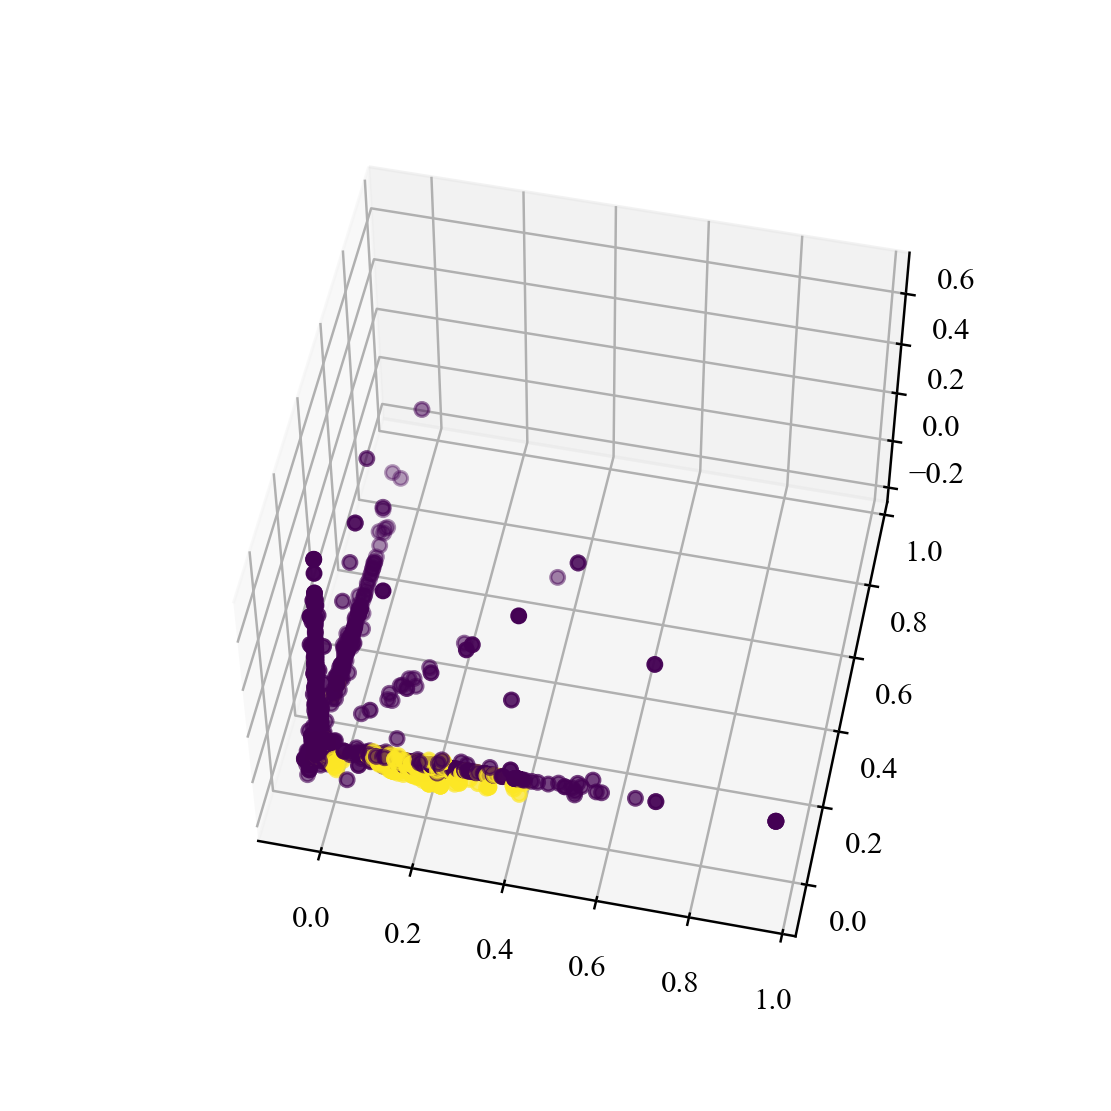

In [254]:
from sklearn import decomposition
plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X_reduced.toarray())
A = pca.transform(X_reduced.toarray())
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(A[:,0], A[:,1], A[:,2], c=labels)
plt.show()